# Basic Neural Analysis of Steinmetz Dataset

This notebook performs basic analyses of neural activity including:
1. PSTH analysis aligned to stimulus and choice
2. Comparison of neural responses across brain regions
3. Analysis of fast-spiking vs regular-spiking neurons
4. Trial-to-trial variability analysis

In [3]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer

# Set plotting style
#plt.style.use('seaborn')
sns.set_context("talk")

## 1. Data Loading and Setup

In [4]:
# Initialize data loader and load session
loader = SteinmetzDataLoader()
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Initialize neural analyzer
analyzer = NeuralAnalyzer()

print("Available data keys:", session_data.keys())

Successfully downloaded steinmetz_st.npz
Successfully downloaded steinmetz_wav.npz
Successfully downloaded steinmetz_lfp.npz
Available data keys: dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'waveform_w', 'waveform_u', 'trough_to_peak', 'spikes', 'spikes_passive'])


## 2. PSTH Analysis

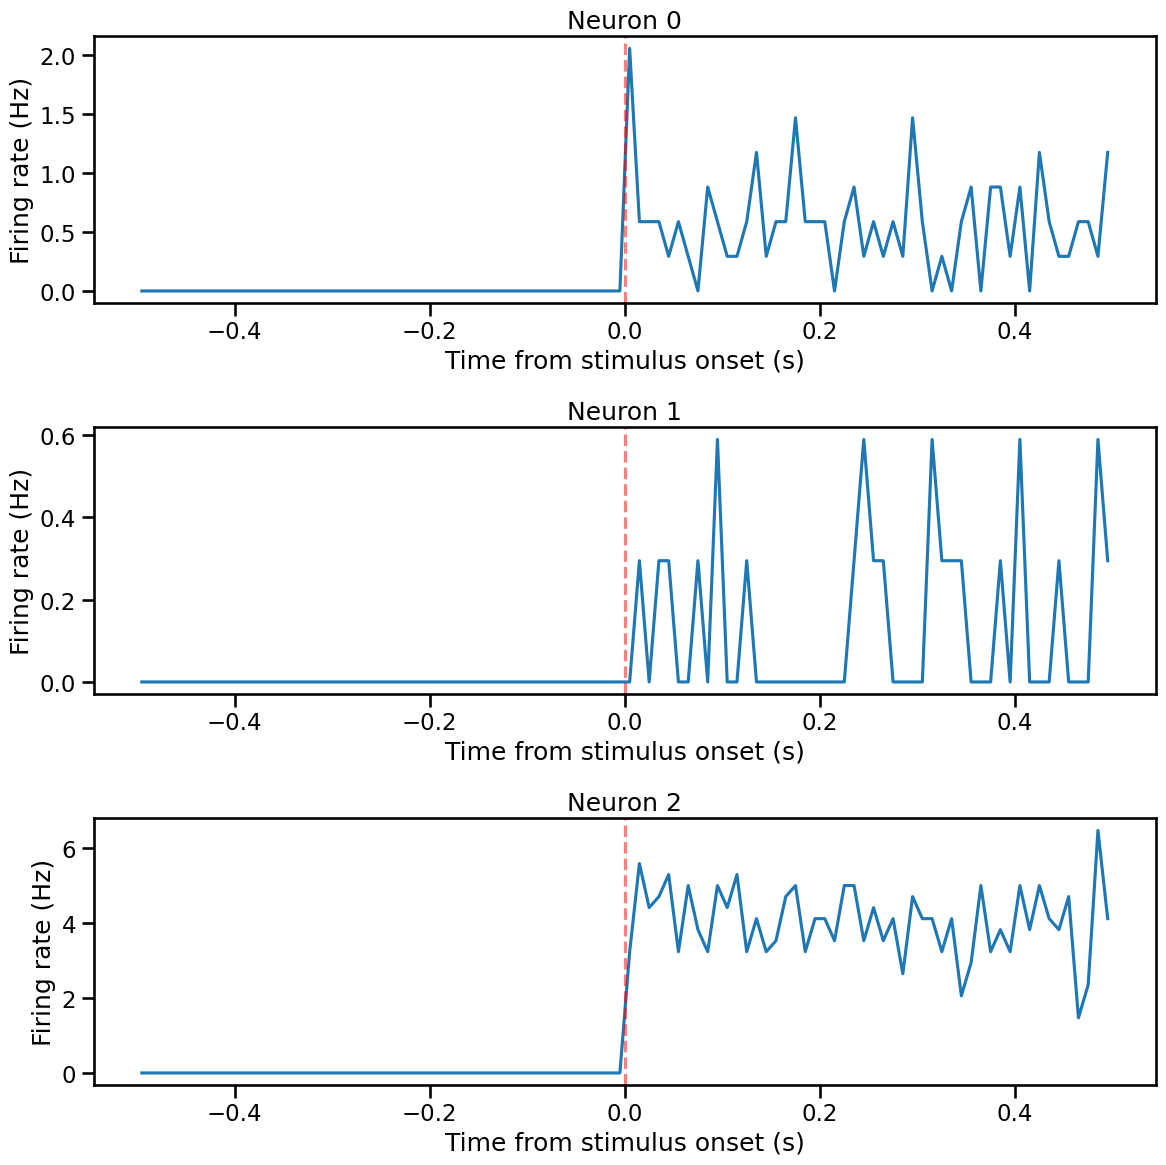

In [5]:
def plot_psth_multiple_neurons(spikes, neuron_indices, time_window=(-0.5, 0.5)):
    """Plot PSTHs for multiple neurons."""
    n_neurons = len(neuron_indices)
    fig, axes = plt.subplots(n_neurons, 1, figsize=(12, 4*n_neurons))
    
    for i, neuron_idx in enumerate(neuron_indices):
        psth, time_bins = analyzer.compute_psth(
            spikes[neuron_idx],
            time_window=time_window
        )
        
        if n_neurons == 1:
            ax = axes
        else:
            ax = axes[i]
            
        ax.plot(time_bins, psth)
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
        ax.set_xlabel('Time from stimulus onset (s)')
        ax.set_ylabel('Firing rate (Hz)')
        ax.set_title(f'Neuron {neuron_idx}')
    
    plt.tight_layout()
    return fig

# Plot PSTHs for first few neurons
example_neurons = [0, 1, 2]
plot_psth_multiple_neurons(session_data['spikes'], example_neurons)
plt.show()

## 3. Neuron Type Analysis

In [6]:
# Identify fast-spiking neurons
is_fast_spiking = loader.get_fast_spiking_neurons(session_data)

# Compute average firing rates
time_bins = np.arange(-0.5, 0.5, 0.01)
firing_rates = loader.compute_firing_rates(session_data['spikes'], time_bins)
mean_rates = np.mean(firing_rates, axis=1)

# Plot firing rate distributions by neuron type
plt.figure(figsize=(10, 6))
plt.hist(mean_rates[is_fast_spiking], bins=20, alpha=0.5, label='Fast-spiking')
plt.hist(mean_rates[~is_fast_spiking], bins=20, alpha=0.5, label='Regular-spiking')
plt.xlabel('Mean firing rate (Hz)')
plt.ylabel('Number of neurons')
plt.title('Firing Rate Distribution by Neuron Type')
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (0,) (11,) 

## 4. Trial-to-Trial Variability

In [ ]:
def compute_fano_factor(spike_counts):
    """Compute Fano factor (variance/mean) across trials."""
    return np.var(spike_counts, axis=1) / np.mean(spike_counts, axis=1)

# Compute spike counts in response window
window = (0, 0.2)  # 200ms after stimulus
n_neurons = len(session_data['spikes'])
n_trials = len(session_data['spikes'][0])
spike_counts = np.zeros((n_neurons, n_trials))

for i, neuron_spikes in enumerate(session_data['spikes']):
    for j, trial_spikes in enumerate(neuron_spikes):
        spike_counts[i, j] = np.sum(
            (trial_spikes >= window[0]) & (trial_spikes < window[1])
        )

# Compute and plot Fano factors
fano_factors = compute_fano_factor(spike_counts)

plt.figure(figsize=(10, 6))
plt.hist(fano_factors, bins=30)
plt.axvline(x=1, color='r', linestyle='--', label='Poisson')
plt.xlabel('Fano Factor')
plt.ylabel('Number of neurons')
plt.title('Distribution of Fano Factors')
plt.legend()
plt.show()

## 5. Response Reliability Analysis

In [ ]:
def compute_response_reliability(firing_rates):
    """Compute trial-to-trial correlation of firing patterns."""
    n_neurons = firing_rates.shape[0]
    reliability = np.zeros(n_neurons)
    
    for i in range(n_neurons):
        # Split trials into two groups and compare
        n_trials = firing_rates.shape[1]
        split = n_trials // 2
        mean1 = np.mean(firing_rates[i, :split], axis=0)
        mean2 = np.mean(firing_rates[i, split:], axis=0)
        reliability[i] = np.corrcoef(mean1, mean2)[0, 1]
    
    return reliability

# Compute response reliability
reliability = compute_response_reliability(firing_rates)

# Plot reliability distribution
plt.figure(figsize=(10, 6))
plt.hist(reliability[~np.isnan(reliability)], bins=30)
plt.xlabel('Response Reliability')
plt.ylabel('Number of neurons')
plt.title('Distribution of Response Reliability')
plt.show()